In [2]:
## Try prediction just using a recursive network 
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import utilities

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load data:
x_data, img_data, y_data = utilities.load_data()


Loading vector data
Loading image data
Preprocessing data


In [3]:
# Split training/validation data
SPLIT_RATIO = 0.6

N_training = int(SPLIT_RATIO*x_data.shape[0])
N_validation = x_data.shape[0]- N_training

x_train = x_data[0:N_training,...]
y_train = y_data[0:N_training]

x_val = x_data[N_training:,...]
y_val = y_data[N_training:]



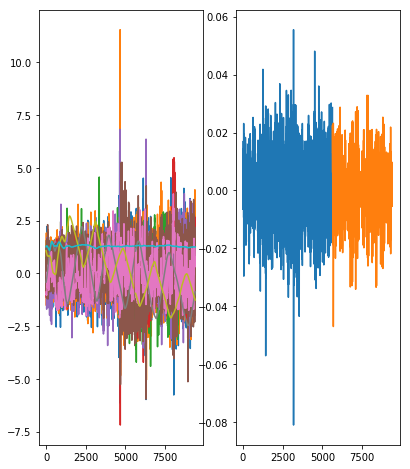

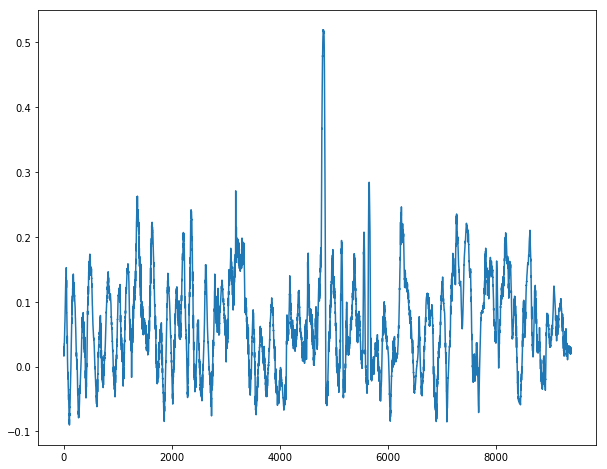

In [4]:
plt.subplot(1,3,1)
plt.plot(x_train)
plt.plot(np.arange(N_training,x_data.shape[0]),x_val)
plt.subplot(1,3,2)
plt.plot(y_train)
plt.plot(np.arange(N_training,x_data.shape[0]),y_val)
plt.show()
plt.plot(np.cumsum(y_data))

In [51]:
# Definition of network:
# rescale the images ~ 64x48
# Try normalizing 
# feed output back in
# see if you can get cats roughly hte same size

OUTPUT_DIM = 1
BATCH_SIZE = 512  # Number of independent samples
R_HISTORY = 1  # length of the time series inputs
N_HIDDEN = 128 # Size of LSTM hidden layer
# 1: works
# 2: works
# 3: works, until ~6k iterations (383 vs 384 error)
# 4: 511 vs 512. step 319
# 5: 638 vs 640. step 492
# 8: 50 too small


sub_batches = R_HISTORY*np.ones(BATCH_SIZE)

class tangoNet(object):

    # Extract features for a single time step
    def extract_features(self, input_data=None, reuse=True):
        if input_data is None:
            input_data = self.data
        x_r = input_data
        
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('dense_1'):
                x_r = tf.layers.dense(x_r, 32, activation=tf.nn.relu)
                layers.append(x_r)
            return layers

    def __init__(self, batch_size, save_path=None, sess=None):
        self.batch_size = tf.constant(batch_size,dtype=tf.int32)
        # r_depth, batch, input_dim
        self.data   = tf.placeholder('float',shape=[R_HISTORY*batch_size,10],name='input_data_seq')
        # batch, output_dim
#        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size, OUTPUT_DIM],name='output_error')
        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size],name='output_error')
        self.lr = tf.placeholder('float',shape=[1],name='lr')
        self.state = tf.placeholder('float', shape=[N_HIDDEN],name='cell_state')

        self.layers = []
        self.features = []
        for k in range(R_HISTORY):
            data = self.data[batch_size*k:batch_size*(k+1),:]
            r = (k!=0)
            self.features.append(self.extract_features(data, reuse=r)[-1])
        
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('core_0'):
                x_r = self.features
                self.layers.append(x_r)
            with tf.variable_scope('core_1'):
#                lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(N_HIDDEN),tf.contrib.rnn.BasicLSTMCell(N_HIDDEN),tf.contrib.rnn.BasicLSTMCell(N_HIDDEN)])
                lstm_cell = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN)
                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32, sequence_length=sub_batches)
                self.layers.append(x_r[-1])
                x_r = tf.concat(x_r, axis=0)                
            with tf.variable_scope('core_end'):
                W = tf.get_variable("weights", shape=[N_HIDDEN,OUTPUT_DIM])
                b = tf.get_variable("bias", shape=[OUTPUT_DIM])
                x_r = tf.matmul(x_r, W) + b
                self.layers.append(x_r)
        self.states = states
        self.prediction = tf.reshape(x_r, [-1, OUTPUT_DIM])

        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        # Needs a bit of work still
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs[-1], self.prediction[-1])))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.rmse)


initializing...
Training
Step:  2000  MSE:  0.164829796716  Val:  0.0133461491903 LR:  0.00826168623836


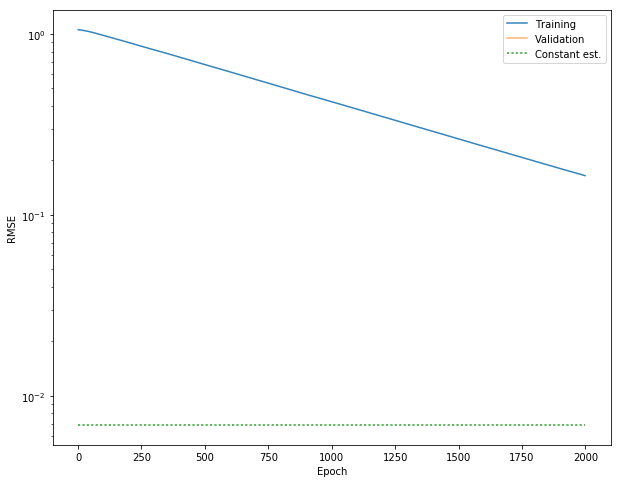

Step:  4000  MSE:  0.0290264507857  Val:  0.00563018666871 LR:  0.00067572904906


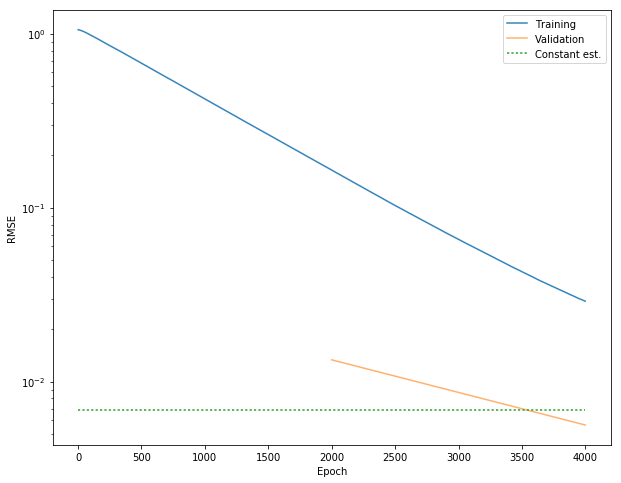

Step:  6000  MSE:  0.0100545665409  Val:  0.00624324444216 LR:  5.52683477162e-05


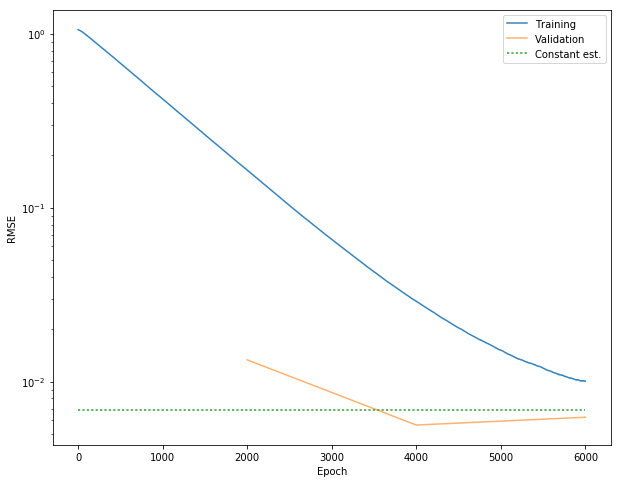

Step:  8000  MSE:  0.00731440248255  Val:  0.00500646143919 LR:  4.52043650266e-06


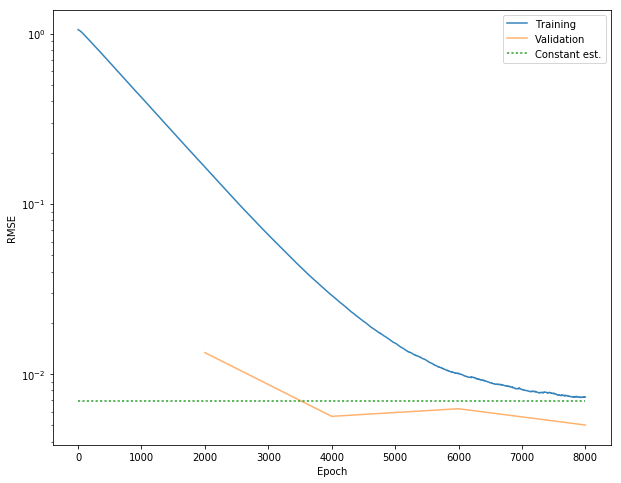

Step:  10000  MSE:  0.00673943779745  Val:  0.00465705097886 LR:  3.6972963765e-07


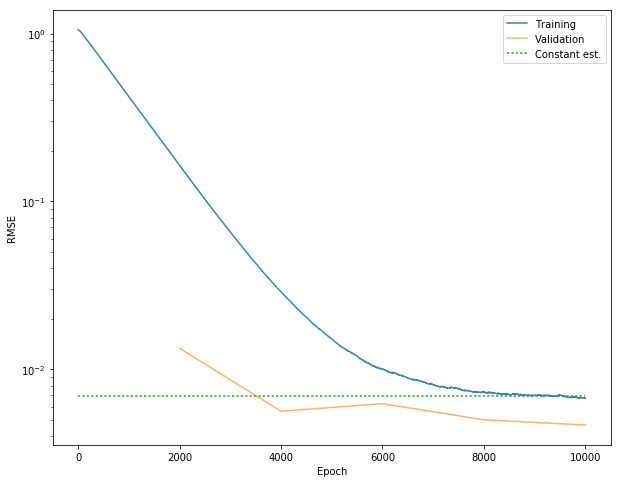

In [ ]:
import utilities

# simple parameters:
disp_period = 2000
training_iters = 40000


print('initializing...')
lr = 0.01
lr_decay = 0.99
with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = '/media/Big_Data/stefantj/tangonet.ckpt'

    model = tangoNet(batch_size = BATCH_SIZE, sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    naive_history = []
    
    # Launch the graph
    sess.run(init)
    step = 1
    ind_train = []
    train_inds = []
    val_inds = []

    smoothed_train = []
    smooth_val = 1-0.999

    print('Training')
    # Keep training until reach max iterations
    state = np.zeros(N_HIDDEN);
    while step  < training_iters:
        if step % 100 is 0:
            lr *= lr_decay
        if step % 2000 is 0:
            lr *= 0.1
        lr = np.max([lr, 0.00000001])
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY,BATCH_SIZE, x_train, y_train)
        
        # Run optimization op (backprop)
        o,mse,state = sess.run([model.optimizer,model.rmse, model.state], feed_dict={model.state: state, model.data: batch_x, model.errs: batch_y, model.lr:[lr]})
        train_inds.append(step)
        if step > 1:
            train_history.append(mse*smooth_val + (1-smooth_val)*train_history[-1])
        else:
            train_history.append(mse)
            
        step += 1
        if step % disp_period is 0:
            # Calculate val accuracy:
            N_smooth = 10;
            batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY,BATCH_SIZE, x_val,y_val)
            state_copy = state.copy()
            vmse = sess.run(model.rmse, feed_dict={model.state: state_copy,model.data: batch_x, model.errs: batch_y})
            val_history.append(vmse/N_smooth)
            val_inds.append(step)
            
            for smooth_num in range(N_smooth-1):
                batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY,BATCH_SIZE, x_val,y_val)
                vmse = sess.run(model.rmse, feed_dict={model.state: state_copy,model.data: batch_x, model.errs: batch_y})
                val_history[-1]+=(vmse/N_smooth)

            
            print('Step: ', step, ' MSE: ', train_history[-1], ' Val: ', val_history[-1], 'LR: ', lr)
            plt.semilogy(train_inds, train_history,alpha=0.9)
            plt.semilogy(val_inds, val_history,alpha=0.6)
            plt.semilogy([0,step],[0.0069,0.0069],':')
            plt.legend(['Training','Validation','Constant est.'])
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.show()


In [49]:

# Compute sequence prediction:
print('Computing sequence prediction - this may take a while. ')
state = np.zeros(N_HIDDEN)
m_state = np.zeros(y_data.shape[0])
y_pred = np.zeros(y_data.shape[0])
for k in range( y_data.shape[0]-BATCH_SIZE*R_HISTORY):
    if k % 1000 is 0:
        print('k = ', k)
    batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY, BATCH_SIZE,x_data,y_data, k)
    pred,state = sess.run([model.prediction,model.state], feed_dict={model.state:state,model.data: batch_x, model.errs: batch_y})
    m_state[k] = np.max(state)
    y_pred[k] = pred[-1]
np.save('rnn_prediction', y_pred)
print('Done.')

Computing sequence prediction - this may take a while. 
k =  0
k =  1000
k =  2000
k =  3000
k =  4000
k =  5000
k =  6000
k =  7000
k =  8000
k =  9000
Done.


0.0069855814869


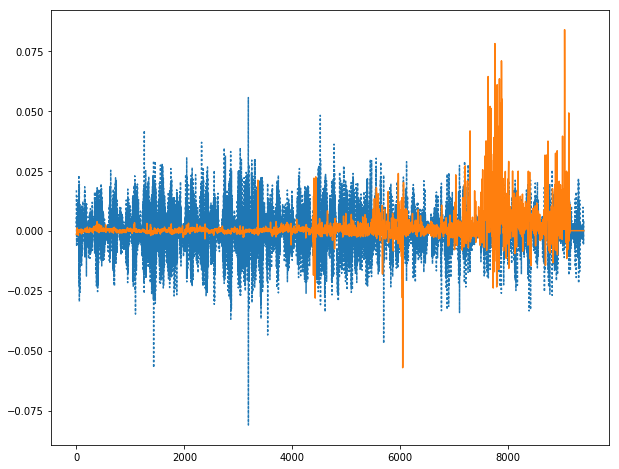

In [50]:
plt.plot(y_data,':')
plt.plot(y_pred)
print(train_history[-1])


In [ ]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Sequence-to-sequence model with an attention mechanism."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


class Seq2SeqModel(object):
  def __init__(self,
               source_vocab_size,
               target_vocab_size,
               buckets,
               size,
               num_layers,
               max_gradient_norm,
               batch_size,
               learning_rate,
               learning_rate_decay_factor,
               use_lstm=False,
               num_samples=512,
               forward_only=False,
               dtype=tf.float32):
    """Create the model.
    Args:
      source_vocab_size: size of the source vocabulary.
      target_vocab_size: size of the target vocabulary.
      buckets: a list of pairs (I, O), where I specifies maximum input length
        that will be processed in that bucket, and O specifies maximum output
        length. Training instances that have inputs longer than I or outputs
        longer than O will be pushed to the next bucket and padded accordingly.
        We assume that the list is sorted, e.g., [(2, 4), (8, 16)].
      size: number of units in each layer of the model.
      num_layers: number of layers in the model.
      max_gradient_norm: gradients will be clipped to maximally this norm.
      batch_size: the size of the batches used during training;
        the model construction is independent of batch_size, so it can be
        changed after initialization if this is convenient, e.g., for decoding.
      learning_rate: learning rate to start with.
      learning_rate_decay_factor: decay learning rate by this much when needed.
      use_lstm: if true, we use LSTM cells instead of GRU cells.
      num_samples: number of samples for sampled softmax.
      forward_only: if set, we do not construct the backward pass in the model.
      dtype: the data type to use to store internal variables.
    """
    self.source_vocab_size = source_vocab_size
    self.target_vocab_size = target_vocab_size
    self.buckets = buckets
    self.batch_size = batch_size
    self.learning_rate = tf.Variable(
        float(learning_rate), trainable=False, dtype=dtype)
    self.learning_rate_decay_op = self.learning_rate.assign(
        self.learning_rate * learning_rate_decay_factor)
    self.global_step = tf.Variable(0, trainable=False)

    # If we use sampled softmax, we need an output projection.
    output_projection = None
    softmax_loss_function = None
    # Sampled softmax only makes sense if we sample less than vocabulary size.
    if num_samples > 0 and num_samples < self.target_vocab_size:
      w_t = tf.get_variable("proj_w", [self.target_vocab_size, size], dtype=dtype)
      w = tf.transpose(w_t)
      b = tf.get_variable("proj_b", [self.target_vocab_size], dtype=dtype)
      output_projection = (w, b)

      def sampled_loss(labels, logits):
        labels = tf.reshape(labels, [-1, 1])
        # We need to compute the sampled_softmax_loss using 32bit floats to
        # avoid numerical instabilities.
        local_w_t = tf.cast(w_t, tf.float32)
        local_b = tf.cast(b, tf.float32)
        local_inputs = tf.cast(logits, tf.float32)
        return tf.cast(
            tf.nn.sampled_softmax_loss(
                weights=local_w_t,
                biases=local_b,
                labels=labels,
                inputs=local_inputs,
                num_sampled=num_samples,
                num_classes=self.target_vocab_size),
            dtype)
      softmax_loss_function = sampled_loss

    # Create the internal multi-layer cell for our RNN.
    def single_cell():
      return tf.contrib.rnn.GRUCell(size)
    if use_lstm:
      def single_cell():
        return tf.contrib.rnn.BasicLSTMCell(size)
    cell = single_cell()
    if num_layers > 1:
      cell = tf.contrib.rnn.MultiRNNCell([single_cell() for _ in range(num_layers)])

    # The seq2seq function: we use embedding for the input and attention.
    def seq2seq_f(encoder_inputs, decoder_inputs, do_decode):
      return tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
          encoder_inputs,
          decoder_inputs,
          cell,
          num_encoder_symbols=source_vocab_size,
          num_decoder_symbols=target_vocab_size,
          embedding_size=size,
          output_projection=output_projection,
          feed_previous=do_decode,
          dtype=dtype)

    # Feeds for inputs.
    self.encoder_inputs = []
    self.decoder_inputs = []
    self.target_weights = []
    for i in xrange(buckets[-1][0]):  # Last bucket is the biggest one.
      self.encoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                name="encoder{0}".format(i)))
    for i in xrange(buckets[-1][1] + 1):
      self.decoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                name="decoder{0}".format(i)))
      self.target_weights.append(tf.placeholder(dtype, shape=[None],
                                                name="weight{0}".format(i)))

    # Our targets are decoder inputs shifted by one.
    targets = [self.decoder_inputs[i + 1]
               for i in xrange(len(self.decoder_inputs) - 1)]

    # Training outputs and losses.
    if forward_only:
      self.outputs, self.losses = tf.contrib.legacy_seq2seq.model_with_buckets(
          self.encoder_inputs, self.decoder_inputs, targets,
          self.target_weights, buckets, lambda x, y: seq2seq_f(x, y, True),
          softmax_loss_function=softmax_loss_function)
      # If we use output projection, we need to project outputs for decoding.
      if output_projection is not None:
        for b in xrange(len(buckets)):
          self.outputs[b] = [
              tf.matmul(output, output_projection[0]) + output_projection[1]
              for output in self.outputs[b]
          ]
    else:
      self.outputs, self.losses = tf.contrib.legacy_seq2seq.model_with_buckets(
          self.encoder_inputs, self.decoder_inputs, targets,
          self.target_weights, buckets,
          lambda x, y: seq2seq_f(x, y, False),
          softmax_loss_function=softmax_loss_function)

    # Gradients and SGD update operation for training the model.
    params = tf.trainable_variables()
    if not forward_only:
      self.gradient_norms = []
      self.updates = []
      opt = tf.train.GradientDescentOptimizer(self.learning_rate)
      for b in xrange(len(buckets)):
        gradients = tf.gradients(self.losses[b], params)
        clipped_gradients, norm = tf.clip_by_global_norm(gradients,
                                                         max_gradient_norm)
        self.gradient_norms.append(norm)
        self.updates.append(opt.apply_gradients(
            zip(clipped_gradients, params), global_step=self.global_step))

    self.saver = tf.train.Saver(tf.global_variables())

  def step(self, session, encoder_inputs, decoder_inputs, target_weights,
           bucket_id, forward_only):
    """Run a step of the model feeding the given inputs.

    Args:
      session: tensorflow session to use.
      encoder_inputs: list of numpy int vectors to feed as encoder inputs.
      decoder_inputs: list of numpy int vectors to feed as decoder inputs.
      target_weights: list of numpy float vectors to feed as target weights.
      bucket_id: which bucket of the model to use.
      forward_only: whether to do the backward step or only forward.

    Returns:
      A triple consisting of gradient norm (or None if we did not do backward),
      average perplexity, and the outputs.

    Raises:
      ValueError: if length of encoder_inputs, decoder_inputs, or
        target_weights disagrees with bucket size for the specified bucket_id.
    """
    # Check if the sizes match.
    encoder_size, decoder_size = self.buckets[bucket_id]
    if len(encoder_inputs) != encoder_size:
      raise ValueError("Encoder length must be equal to the one in bucket,"
                       " %d != %d." % (len(encoder_inputs), encoder_size))
    if len(decoder_inputs) != decoder_size:
      raise ValueError("Decoder length must be equal to the one in bucket,"
                       " %d != %d." % (len(decoder_inputs), decoder_size))
    if len(target_weights) != decoder_size:
      raise ValueError("Weights length must be equal to the one in bucket,"
                       " %d != %d." % (len(target_weights), decoder_size))

    # Input feed: encoder inputs, decoder inputs, target_weights, as provided.
    input_feed = {}
    for l in xrange(encoder_size):
      input_feed[self.encoder_inputs[l].name] = encoder_inputs[l]
    for l in xrange(decoder_size):
      input_feed[self.decoder_inputs[l].name] = decoder_inputs[l]
      input_feed[self.target_weights[l].name] = target_weights[l]

    # Since our targets are decoder inputs shifted by one, we need one more.
    last_target = self.decoder_inputs[decoder_size].name
    input_feed[last_target] = np.zeros([self.batch_size], dtype=np.int32)

    # Output feed: depends on whether we do a backward step or not.
    if not forward_only:
      output_feed = [self.updates[bucket_id],  # Update Op that does SGD.
                     self.gradient_norms[bucket_id],  # Gradient norm.
                     self.losses[bucket_id]]  # Loss for this batch.
    else:
      output_feed = [self.losses[bucket_id]]  # Loss for this batch.
      for l in xrange(decoder_size):  # Output logits.
        output_feed.append(self.outputs[bucket_id][l])

    outputs = session.run(output_feed, input_feed)
    if not forward_only:
      return outputs[1], outputs[2], None  # Gradient norm, loss, no outputs.
    else:
      return None, outputs[0], outputs[1:]  # No gradient norm, loss, outputs.

  def get_batch(self, data, bucket_id):
    """Get a random batch of data from the specified bucket, prepare for step.

    To feed data in step(..) it must be a list of batch-major vectors, while
    data here contains single length-major cases. So the main logic of this
    function is to re-index data cases to be in the proper format for feeding.

    Args:
      data: a tuple of size len(self.buckets) in which each element contains
        lists of pairs of input and output data that we use to create a batch.
      bucket_id: integer, which bucket to get the batch for.

    Returns:
      The triple (encoder_inputs, decoder_inputs, target_weights) for
      the constructed batch that has the proper format to call step(...) later.
    """
    encoder_size, decoder_size = self.buckets[bucket_id]
    encoder_inputs, decoder_inputs = [], []

    # Get a random batch of encoder and decoder inputs from data,
    # pad them if needed, reverse encoder inputs and add GO to decoder.
    for _ in xrange(self.batch_size):
      encoder_input, decoder_input = random.choice(data[bucket_id])

      # Encoder inputs are padded and then reversed.
      encoder_pad = [data_utils.PAD_ID] * (encoder_size - len(encoder_input))
      encoder_inputs.append(list(reversed(encoder_input + encoder_pad)))

      # Decoder inputs get an extra "GO" symbol, and are padded then.
      decoder_pad_size = decoder_size - len(decoder_input) - 1
      decoder_inputs.append([data_utils.GO_ID] + decoder_input +
                            [data_utils.PAD_ID] * decoder_pad_size)

    # Now we create batch-major vectors from the data selected above.
    batch_encoder_inputs, batch_decoder_inputs, batch_weights = [], [], []

    # Batch encoder inputs are just re-indexed encoder_inputs.
    for length_idx in xrange(encoder_size):
      batch_encoder_inputs.append(
          np.array([encoder_inputs[batch_idx][length_idx]
                    for batch_idx in xrange(self.batch_size)], dtype=np.int32))

    # Batch decoder inputs are re-indexed decoder_inputs, we create weights.
    for length_idx in xrange(decoder_size):
      batch_decoder_inputs.append(
          np.array([decoder_inputs[batch_idx][length_idx]
                    for batch_idx in xrange(self.batch_size)], dtype=np.int32))

      # Create target_weights to be 0 for targets that are padding.
      batch_weight = np.ones(self.batch_size, dtype=np.float32)
      for batch_idx in xrange(self.batch_size):
        # We set weight to 0 if the corresponding target is a PAD symbol.
        # The corresponding target is decoder_input shifted by 1 forward.
        if length_idx < decoder_size - 1:
          target = decoder_inputs[batch_idx][length_idx + 1]
        if length_idx == decoder_size - 1 or target == data_utils.PAD_ID:
          batch_weight[batch_idx] = 0.0
      batch_weights.append(batch_weight)
    return batch_encoder_inputs, batch_decoder_inputs, batch_weights

In [ ]:

tf.app.flags.DEFINE_float("learning_rate", 0.5, "Learning rate.")
tf.app.flags.DEFINE_float("learning_rate_decay_factor", 0.99,
                          "Learning rate decays by this much.")
tf.app.flags.DEFINE_float("max_gradient_norm", 5.0,
                          "Clip gradients to this norm.")
tf.app.flags.DEFINE_integer("batch_size", 64,
                            "Batch size to use during training.")
tf.app.flags.DEFINE_integer("size", 1024, "Size of each model layer.")
tf.app.flags.DEFINE_integer("num_layers", 3, "Number of layers in the model.")
tf.app.flags.DEFINE_integer("from_vocab_size", 40000, "English vocabulary size.")
tf.app.flags.DEFINE_integer("to_vocab_size", 40000, "French vocabulary size.")
tf.app.flags.DEFINE_string("from_train_data", None, "Training data.")
tf.app.flags.DEFINE_string("to_train_data", None, "Training data.")
tf.app.flags.DEFINE_string("from_dev_data", None, "Training data.")
tf.app.flags.DEFINE_string("to_dev_data", None, "Training data.")
tf.app.flags.DEFINE_integer("max_train_data_size", 0,
                            "Limit on the size of training data (0: no limit).")
tf.app.flags.DEFINE_integer("steps_per_checkpoint", 200,
                            "How many training steps to do per checkpoint.")
tf.app.flags.DEFINE_boolean("decode", False,
                            "Set to True for interactive decoding.")
tf.app.flags.DEFINE_boolean("self_test", False,
                            "Run a self-test if this is set to True.")
tf.app.flags.DEFINE_boolean("use_fp16", False,
                            "Train using fp16 instead of fp32.")

FLAGS = tf.app.flags.FLAGS


# We use a number of buckets and pad to the closest one for efficiency.
# See seq2seq_model.Seq2SeqModel for details of how they work.
_buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]



def read_data():
  """Read data from source and target files and put into buckets.
  Args:
    source_path: path to the files with token-ids for the source language.
    target_path: path to the file with token-ids for the target language;
      it must be aligned with the source file: n-th line contains the desired
      output for n-th line from the source_path.
    max_size: maximum number of lines to read, all other will be ignored;
      if 0 or None, data files will be read completely (no limit).
  Returns:
    data_set: a list of length len(_buckets); data_set[n] contains a list of
      (source, target) pairs read from the provided data files that fit
      into the n-th bucket, i.e., such that len(source) < _buckets[n][0] and
      len(target) < _buckets[n][1]; source and target are lists of token-ids.
  """
  data_set = [[] for _ in _buckets]
  with tf.gfile.GFile(source_path, mode="r") as source_file:
    with tf.gfile.GFile(target_path, mode="r") as target_file:
      source, target = source_file.readline(), target_file.readline()
      counter = 0
      while source and target and (not max_size or counter < max_size):
        counter += 1
        if counter % 100000 == 0:
          print("  reading data line %d" % counter)
          sys.stdout.flush()
        source_ids = [int(x) for x in source.split()]
        target_ids = [int(x) for x in target.split()]
        target_ids.append(data_utils.EOS_ID)
        for bucket_id, (source_size, target_size) in enumerate(_buckets):
          if len(source_ids) < source_size and len(target_ids) < target_size:
            data_set[bucket_id].append([source_ids, target_ids])
            break
        source, target = source_file.readline(), target_file.readline()
  return data_set



def create_model(session, forward_only):
  """Create translation model and initialize or load parameters in session."""
  dtype = tf.float16 if FLAGS.use_fp16 else tf.float32
  model = seq2seq_model.Seq2SeqModel(
      FLAGS.from_vocab_size,
      FLAGS.to_vocab_size,
      _buckets,
      FLAGS.size,
      FLAGS.num_layers,
      FLAGS.max_gradient_norm,
      FLAGS.batch_size,
      FLAGS.learning_rate,
      FLAGS.learning_rate_decay_factor,
      forward_only=forward_only,
      dtype=dtype)
  ckpt = tf.train.get_checkpoint_state(FLAGS.train_dir)
  if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
    model.saver.restore(session, ckpt.model_checkpoint_path)
  else:
    print("Created model with fresh parameters.")
    session.run(tf.global_variables_initializer())
  return model
